In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set style for the plots
plt.style.use('seaborn-v0_8')

Epoch 1/200


c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2595 - val_loss: 0.1442
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0662 - val_loss: 0.1222
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0622 - val_loss: 0.1056
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0539 - val_loss: 0.0715
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0376 - val_loss: 0.0386
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0332 - val_loss: 0.0411
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0282 - val_loss: 0.0327
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0269 - val_loss: 0.0242
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0281 - val_loss: 0.0278
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0237 - val_loss: 0.0200
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0237 - val_loss: 0.0392
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

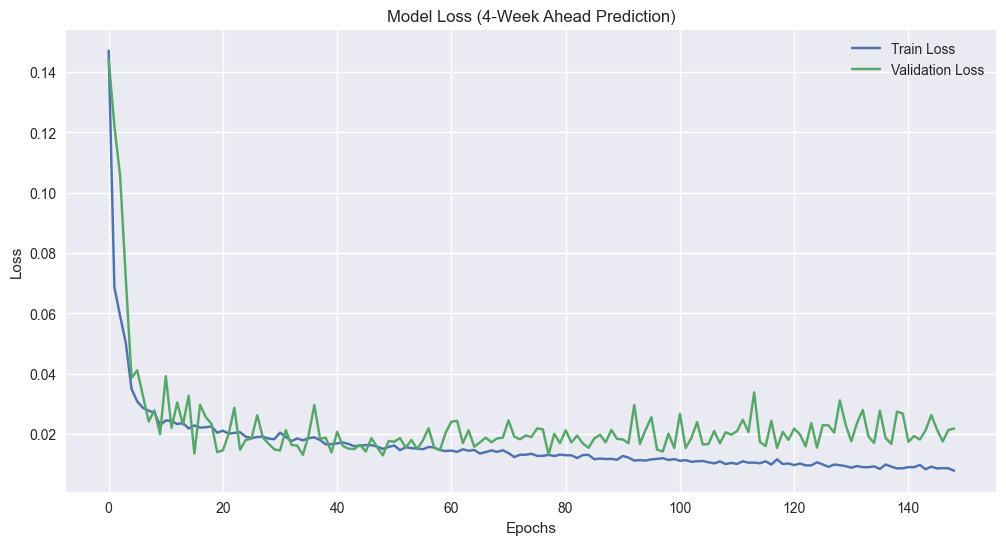

In [94]:
# Load and preprocess the data
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])
data = (
    df.set_index("timestamp")["value"]
      .resample("W-SUN").mean()
      .interpolate()
)

# Convert series to dataframe
data = data.to_frame()


# Define the anchor template for max level calculation
anchor_template  = [
    ("11-01", 237.30), ("12-15", 237.30), ("01-01", 239.61),
    ("02-01", 241.71), ("03-01", 242.70), ("04-01", 244.10),
    ("05-01", 244.95),
]

def compute_max_level_series(dates):
    # (Keep the function definition from your SARIMA code)
    def max_level_on(date):
        y0 = date.year if date.month >= 11 else date.year - 1
        pts = []
        for md, lvl in anchor_template:
            mon, day = map(int, md.split("-"))
            year = y0 if mon >= 11 else y0 + 1
            # Handle potential errors creating timestamps (e.g., Feb 29)
            try:
                pts.append((pd.Timestamp(year, mon, day), lvl))
            except ValueError: # Skip invalid dates like Feb 29 in non-leap years if needed
                 if mon == 2 and day == 29:
                     pts.append((pd.Timestamp(year, 2, 28), lvl)) # Use Feb 28 instead
                 else:
                     raise # Re-raise other errors
        pts.sort(key=lambda x: x[0])
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1] # Fallback

    return pd.Series([max_level_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(data.index)



# Split the data into train, validation, and test sets
train_data = data[:'2017-12-31']
validation_data = data['2018-01-01':'2020-12-31']
test_data = data['2021-01-01':]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
validation_scaled = scaler.transform(validation_data)
test_scaled = scaler.transform(test_data)

# Function to create datasets with lookback and forecast_horizon
def create_dataset_with_horizon(dataset, lookback=52, forecast_horizon=4):
    X, y = [], []
    for i in range(lookback, len(dataset) - forecast_horizon + 1):
        X.append(dataset[i-lookback:i, 0])
        # Target is 4 weeks ahead
        y.append(dataset[i + forecast_horizon - 1, 0])
    return np.array(X), np.array(y)

# Parameters
lookback = 52  # 1 year of weekly data
forecast_horizon = 4  # 4 weeks ahead prediction

# Create train dataset with 4-week ahead target
X_train, y_train = create_dataset_with_horizon(train_scaled, lookback, forecast_horizon)

# For validation, we need to handle the overlap between training and validation periods
# First, prepare a combined array for creating the validation dataset
train_val_combined = np.vstack((train_scaled, validation_scaled))

# We want the first prediction to be for the first week of 2019
# First, find the index that corresponds to the first week of 2019
start_of_2019 = pd.Timestamp('2019-01-01')
first_week_2019_idx = np.where(validation_data.index >= start_of_2019)[0][0]

# Create the combined array for both train and validation data
train_val_combined = np.vstack((train_scaled, validation_scaled))

# Create validation dataset with predictions starting from the first week of 2019
X_val, y_val = [], []

# For each target week starting from first week of 2019
for target_idx in range(first_week_2019_idx, len(validation_data)):
    # The target is at this position in the combined array
    target_pos = len(train_scaled) + target_idx
    
    # For a 4-week ahead prediction, the input sequence ends 4 weeks before the target
    input_end_pos = target_pos - forecast_horizon + 1
    
    # The input sequence starts 'lookback' weeks before that
    input_start_pos = input_end_pos - lookback
    
    # Extract the input sequence and target
    if input_start_pos >= 0:  # Ensure we have enough historical data
        input_seq = train_val_combined[input_start_pos:input_end_pos, 0]
        target_val = train_val_combined[target_pos, 0]
        
        X_val.append(input_seq)
        y_val.append(target_val)

X_val, y_val = np.array(X_val), np.array(y_val)

# Check when our first prediction will be
first_target_date = validation_data.index[first_week_2019_idx]

# Reshape inputs to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.1))
model.add(LSTM(32))
model.add(Dropout(0.1))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (4-Week Ahead Prediction)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
# Make predictions for validation period
validation_predictions = model.predict(X_val, verbose=0)

# Get the actual values from y_val
validation_actual = y_val

# Get the dates for validation predictions - these are the actual target dates
validation_pred_dates = validation_data.index[first_week_2019_idx:first_week_2019_idx+len(X_val)]
validation_max_levels = max_level[validation_pred_dates]

# Convert predictions back to original scale
validation_predictions = scaler.inverse_transform(validation_predictions)
validation_actual = scaler.inverse_transform(validation_actual.reshape(-1, 1))

# Capping
MIN_VAL = 205
predictions_capped = np.maximum(MIN_VAL, validation_predictions.flatten())
predictions_final = np.minimum(predictions_capped, validation_max_levels)

# Create a DataFrame for validation results
validation_results = pd.DataFrame({
    'Date': validation_pred_dates,
    'Actual': validation_actual.flatten(),
    'Predicted': predictions_final
})
validation_results.set_index('Date', inplace=True)


# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(validation_results['Actual'], validation_results['Predicted']))
mae = mean_absolute_error(validation_results['Actual'], validation_results['Predicted'])

metrics_df = pd.DataFrame(
    {"Metric": ["MAE", "RMSE"],
     "Value":  [mae,   rmse]}
)

metrics_df

,Metric,Value
0,MAE,2.329385
1,RMSE,3.086411


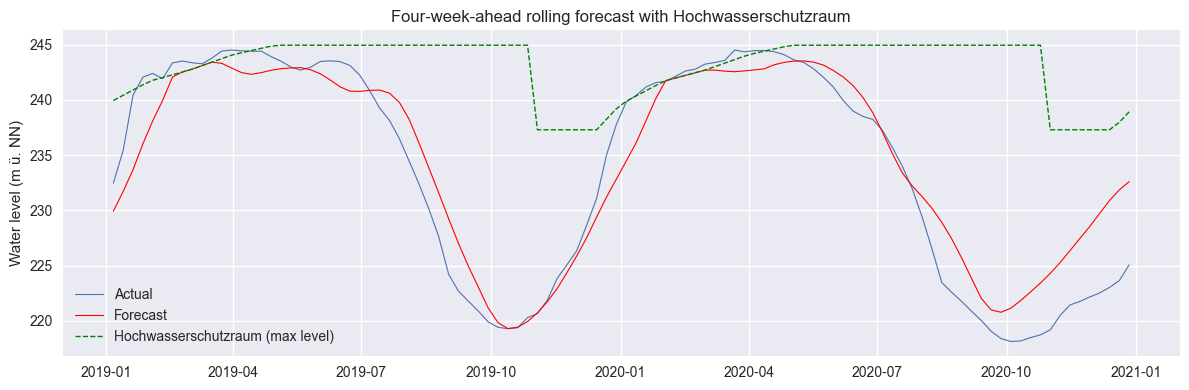

In [97]:
fig, ax = plt.subplots(figsize=(12,4))

# 1) plot actuals & forecasts
ax.plot(validation_results.index, validation_results['Actual'], label='Actual', lw=.8)
ax.plot(validation_results.index, validation_results['Predicted'], label='Forecast', color='red', lw=.8)

# 2) plot the buffer‐level (max allowed) as a dashed line
ax.plot(validation_max_levels,
        label='Hochwasserschutzraum (max level)',
        color='green', linestyle='--', lw=1)


ax.set_title("Four-week-ahead rolling forecast with Hochwasserschutzraum")
ax.set_ylabel("Water level (m ü. NN)")
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()